The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: teacher_image.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: student_image.png
Displaying Generated Images:
Teacher Image:


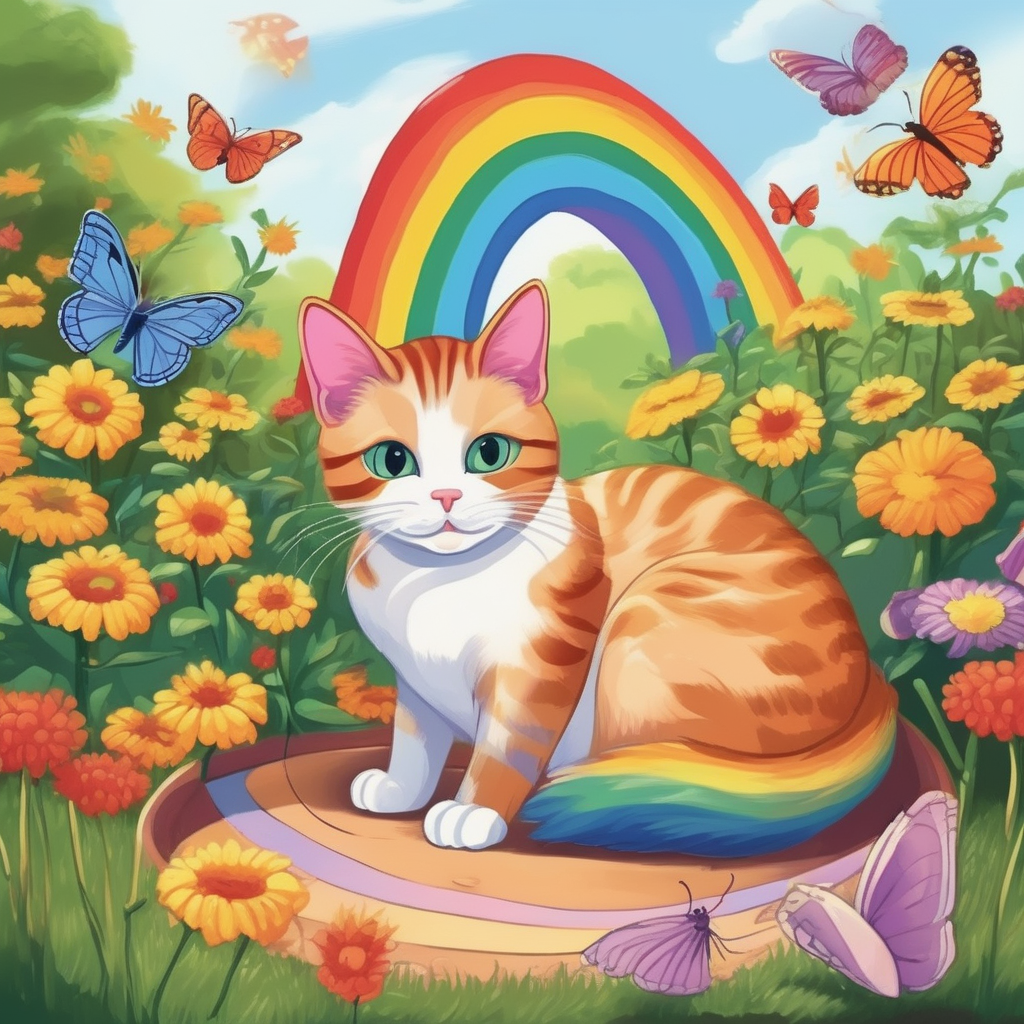

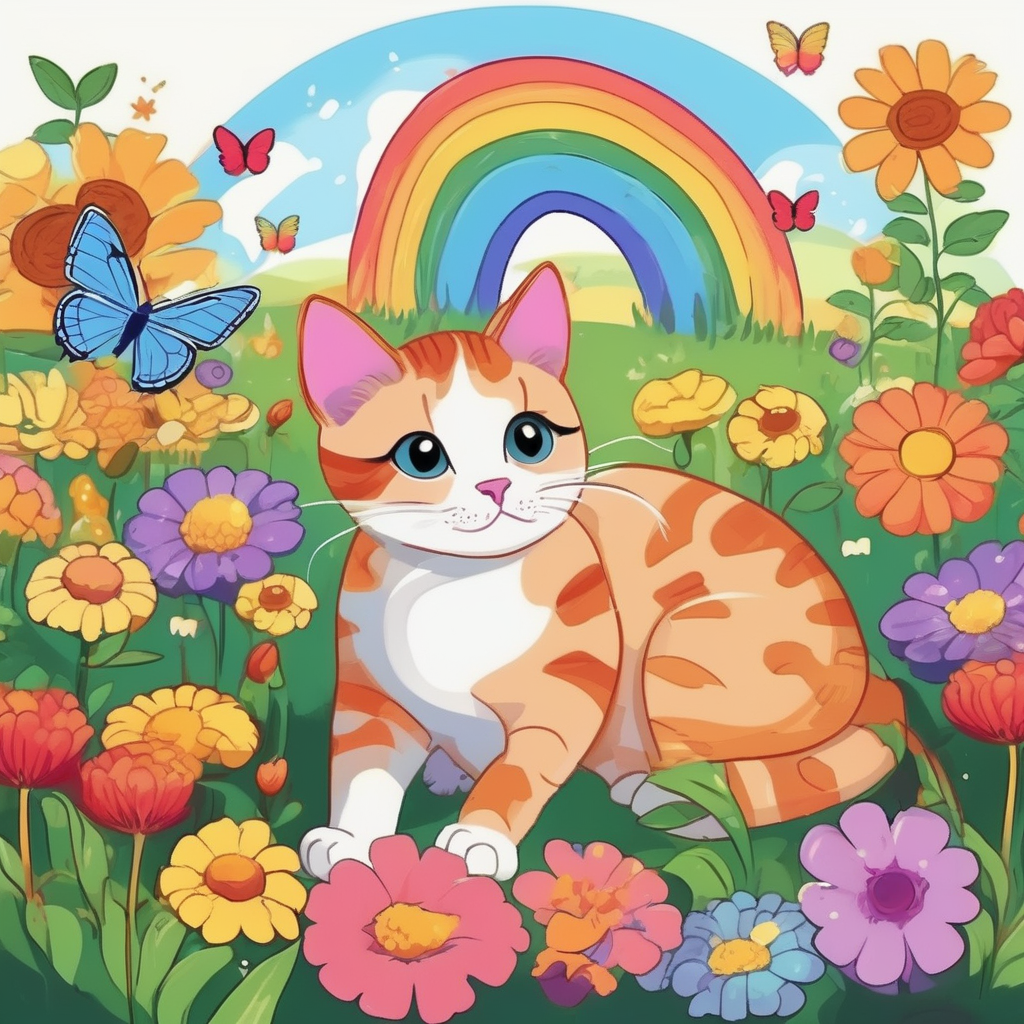

Student Image:

Saved files:
student_image.png
teacher_image.png


In [ ]:
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import torch
from IPython.display import Image as IPImage, display
import os

# Load Stable Diffusion XL for image generation
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to("cuda")

# Function to generate an image using Stable Diffusion
def generate_image(prompt, output_path, style=None):
    if style:
        prompt += f", {style}"  # Add style to the prompt if provided

    # Generate image with a fixed seed for consistency
    generator = torch.manual_seed(43)  # Seed ensures reproducibility
    image = pipe(prompt=prompt, num_inference_steps=50, generator=generator, guidance_scale=7.5).images[0]
    image.save(output_path)
    print(f"Image saved to: {output_path}")
    return output_path

# Main function to generate images
def main():
    # Define prompts
    teacher_prompt = "A cat painting a rainbow on a canvas in a sunny garden, surrounded by butterflies."
    student_prompt = "a cat with rainbow painting , sunny garden and flowers and butterflies"

    # Generate teacher and student images
    teacher_image_path = generate_image(teacher_prompt, "teacher_image.png", style="cartoon style")
    student_image_path = generate_image(student_prompt, "student_image.png", style="cartoon style")

    # Display the generated images
    print("Displaying Generated Images:")
    print("Teacher Image:")
    display(IPImage(teacher_image_path))

    print("Student Image:")
    display(IPImage(student_image_path))

    # Show saved files
    print("\nSaved files:")
    for file in os.listdir("."):
        if file.endswith(".png"):
            print(file)

# Run the main function
if __name__ == "__main__":
    main()


In [ ]:
# Import necessary packages
import os
import torch
from transformers import AutoProcessor, MllamaForConditionalGeneration, AutoTokenizer, AutoModel
from PIL import Image


# Determine the device (GPU if available, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model and processor for caption generation
model_name = "Bllossom/llama-3.2-Korean-Bllossom-AICA-5B"
model = MllamaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0"
)
model.to(device)
processor = AutoProcessor.from_pretrained(model_name)
model.eval()


# Function to generate a caption
def generate_caption(image_path, text_input):
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    if w < 500 or h < 500:
        image = image.resize((w * 2, h * 2))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": text_input},
            ],
        }
    ]

    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(image, input_text, add_special_tokens=False, return_tensors="pt").to(device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model.generate(
                **inputs,
                max_new_tokens=512,
                use_cache=True,
                temperature=0.1,
                eos_token_id=processor.tokenizer.convert_tokens_to_ids("<|eot_id|>"),
            )

        response = processor.decode(outputs[0])
        response = response[
            response.rindex("<|start_header_id|>assistant<|end_header_id|>\n\n")
            + len("<|start_header_id|>assistant<|end_header_id|>\n\n") :
        ].replace("<|eot_id|>", "")

        return response
# Example usage
if __name__ == "__main__":
    # Input variables
    teacher_image_path = "/content/teacher_image.png"  # Replace with the path to teacher's image
    student_image_path = "/content/student_image.png"  # Replace with the path to student's image
    teacher_prompt = "A cat painting a rainbow on a canvas in a sunny garden, surrounded by butterflies."
    student_prompt = "a cat with rainbow painting , sunny garden and flowers and butterflies"

    # Generate captions
    teacher_caption = generate_caption(teacher_image_path, "Provide a detailed objects,colors,style,patterns of this image.")
    student_caption = generate_caption(student_image_path, "Provide a detailed objects,colors,style,patterns of this image.")


    print("Teacher Caption:", teacher_caption)
    print("Student Caption:", student_caption)


config.json:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/84.7k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.58G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/835M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.42k [00:00<?, ?B/s]

<ipython-input-2-12138567e5a2>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Teacher Caption: The image depicts a vibrant and whimsical scene. A cat with orange and white fur is sitting on a rainbow-colored platform surrounded by bright yellow and orange flowers. The cat's eyes are large and blue, and its ears are pointed upwards. A butterfly with orange and blue wings is flying around the cat and flowers. The background is a clear blue sky with fluffy white clouds. The overall style of the image is playful and colorful, with a pattern of flowing shapes and soft textures.
Student Caption: The image features a vibrant cartoon cat sitting in a lush green garden. The cat has a prominent orange and white coat, with distinct eye patches and a pink nose. Its legs are visible, and the cat is surrounded by various colorful flowers, including yellow, pink, and purple blooms. A large blue butterfly is perched on a flower, adding to the whimsical scene. The background consists of a rainbow arching over the garden, and the entire scene is rendered in a playful, cartoon-sty

In [ ]:
from transformers import MllamaForConditionalGeneration, MllamaProcessor
import torch

# Load the model and processor
model_name = "Bllossom/llama-3.2-Korean-Bllossom-AICA-5B"
model = MllamaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
processor = MllamaProcessor.from_pretrained(model_name)

# Function to process a text prompt
def generate_response(prompt):
    # Format the messages for the model
    messages = [{"role": "user", "content": [{"type": "text", "text": prompt}]}]
    input_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=input_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=100, temperature=0.1)

    # Decode the output and clean it up to remove system-generated tokens
    raw_response = processor.decode(outputs[0])

    # Extract content after the expected output start point
    if "score =" in raw_response:
        response_start = raw_response.find("score =")
        return raw_response[response_start:].strip()  # Return everything from "score =" onward
    else:
        return raw_response.strip()


# Example captions
caption_teacher = "The image depicts a vibrant and whimsical scene. A cat with orange and white fur is sitting on a rainbow-colored platform surrounded by bright yellow flowers. The cat's eyes are large and blue, and its ears are pointed upwards. Surrounding the cat and flowers are several colorful butterflies, some of which are in motion as if fluttering. The overall style of the image is playful and artistic, with a mix of digital painting and whimsical illustrations"
caption_student = "The image features a vibrant and whimsical scene with a cat as the central character. The cat has a cream and orange coat with striking pink nose and largest pink ear, adorned with a colorful collar. It sits among an array of bright, multicolored flowers, including yellow, pink, red, and purple blooms. The background is a lush green lawn with a rainbow arching over, adding a magical touch. The overall style is playful and cartoonish, with bold lines and a mix of flat illustrations and soft textures."

teacher_prompt = "A cat painting a rainbow on a canvas in a sunny garden, surrounded by butterflies."
student_prompt = "a cat with rainbow painting , sunny garden and flowers and butterflies"

# Comparison prompt
comparison_prompt = (
    f"Here are two captions describing images:\n"
    f"Caption 1 (Teacher): '{caption_teacher}'\n"
    f"Caption 2 (Student): '{caption_student}'\n"
    "Compare these captions and give a score of how much the student's caption is similar to the teacher's caption out of 100. "
    "The score should be over 90 if the main elements (subject, details, surroundings, and style) are matching. "
    "If the captions describe very different images, the score should be below 10. "
    "Provide the answer in the following format:\n"
    "score = ...\n"
    "reason = [one sentence explaining why the score was given]\n"
)


# Feedback prompt
feedback_prompt = (
    f"Here are two prompts for generating images:\n"
    f"Teacher's prompt: '{teacher_prompt}'\n"
    f"Student's prompt: '{student_prompt}'\n"
    "Compare these prompts and give a score of how much the student's prompt aligns with the teacher's prompt out of 100. "
    "The score should be over 90 if the main elements (subject, key features, surroundings, and style) are present and similar. "
    "If the prompts describe very different concepts, the score should be below 10. "
    "Also, generate feedback in one sentence explaining what the student needs to add or modify to make their prompt align more closely with the teacher's. "
    "Provide the feedback in the following format:\n"
    "feedback = [one sentence explanation]\n"
)


# Generate responses
comparison_response = generate_response(comparison_prompt)
feedback_response = generate_response(feedback_prompt)

# Print results
print("Comparison Result:")
print(comparison_response)
print("\nFeedback for Improvement:")
print(feedback_response)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Comparison Result:
score =...
reason = [one sentence explaining why the score was given]
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

score = 95
reason = The student's caption closely matches the teacher's by describing the same vibrant and whimsical scene with a cat, bright flowers, colorful butterflies, and a playful and artistic style, though it slightly varies in the specific color details and textures.<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>assistant<|end_header_id|>

score = 95
reason = The student's caption closely matches the teacher's by describing the same vibrant and whimsical scene with a cat, bright flowers, colorful

Feedback for Improvement:
<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 16 Jan 2025

You are a helpful AI assistant. Please answer the user's questions kindly. 당신은 유능한 AI 어시스턴트 입니다. 사용자의 질문에 대해 친절하게 답변해주세요.<

In [ ]:
# Function to process a text prompt
def generate_response(prompt):
    # Format the input messages for the model
    messages = [{"role": "user", "content": [{"type": "text", "text": prompt}]}]
    input_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=input_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50, temperature=0.1)

    # Decode the raw output
    raw_response = processor.decode(outputs[0])

    # Extract the relevant part of the response
    # Assumes the response starts with "score =" or similar recognizable structure
    if "score =" in raw_response:
        start_index = raw_response.find("score =")
        response = raw_response[start_index:].strip()  # Extract from "score =" onward
    else:
        response = raw_response.strip()  # Fallback if "score =" is missing

    return response

# Example captions
caption_teacher = "The image depicts a vibrant and whimsical scene. A cat with orange and white fur is sitting on a rainbow-colored platform surrounded by bright yellow flowers. The cat's eyes are large and blue, and its ears are pointed upwards. Surrounding the cat and flowers are several colorful butterflies, some of which are in motion as if fluttering. The overall style of the image is playful and artistic, with a mix of digital painting and whimsical illustrations."
caption_student = "The image features a vibrant and whimsical scene with a cat as the central character. The cat has a cream and orange coat with striking pink nose and largest pink ear, adorned with a colorful collar. It sits among an array of bright, multicolored flowers, including yellow, pink, red, and purple blooms. The background is a lush green lawn with a rainbow arching over, adding a magical touch. The overall style is playful and cartoonish, with bold lines and a mix of flat illustrations and soft textures."

teacher_prompt = "햇살 가득한 정원에서 캔버스에 무지개를 그리고 있는 고양이, 나비들로 둘러싸여 있음."
student_prompt = "무지개 그림을 그리고 있는 고양이, 햇살 가득한 정원과 꽃, 그리고 나비들."

# Comparison prompt
comparison_prompt = (
    f"Here are two captions describing images:\n"
    f"Caption 1 (Teacher): '{caption_teacher}'\n"
    f"Caption 2 (Student): '{caption_student}'\n"
    "Compare these captions and give a score of how much the student's caption is similar to the teacher's caption out of 100. "
    "The score should be over 90 if the main elements (subject, details, surroundings, and style) are matching. "
    "If the captions describe very different images, the score should be below 10. "
    "Provide the answer in the following format:\n"
    "score = ...\n"
    "reason = [one sentence explaining why the score was given]\n"
)

# Feedback prompt
feedback_prompt = (
    f"Here are two prompts for generating images:\n"
    f"Teacher's prompt: '{teacher_prompt}'\n"
    f"Student's prompt: '{student_prompt}'\n"
    "Compare these prompts and give a score of how much the student's prompt aligns with the teacher's prompt out of 100. "
    "The score should be over 90 if the main elements (subject, key features, surroundings, and style) are present and similar. "
    "If the prompts describe very different concepts, the score should be below 10. "
    "Additionally, generate feedback in Korean, explaining what the student needs to add or modify to make their prompt align more closely with the teacher's prompt. "
    "The feedback should include hints, such as comparing specific keywords the student used with the teacher's keywords, and suggesting better alternatives. "
    "Provide the answer in the following format:\n"
    "score = ...\n"
    "feedback = [Feedback in Korean, including specific keyword comparisons and suggestions]\n"
)

# Generate responses
comparison_response = generate_response(comparison_prompt)
feedback_response = generate_response(feedback_prompt)

# Print results
print("Comparison Result:")
print(comparison_response)
print("\nFeedback for Improvement:")
print(feedback_response)


Comparison Result:
score =...
reason = [one sentence explaining why the score was given]
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

score = 95
reason = The student's caption closely matches the teacher's by describing the same vibrant and whimsical scene with a cat, bright flowers, colorful butterflies, and a playful and artistic style, though it slightly varies in the specifics of

Feedback for Improvement:
score =...
feedback = [Feedback in Korean, including specific keyword comparisons and suggestions]
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

score = 85
feedback = [학생의 요청은 교사의 요청과 주요 요소를 많이 공유하고 있지만, '고양이'와 '나비들'의 위치에 대한 구체적인 묘사를 추가하면 더
